In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
from pathlib import Path
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1742412335.717768 2992076 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742412335.721465 2992076 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1742412337.490807 2992076 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]

In [3]:
def plot_S1(distribution, q, end_index = 101, ci = True, show_sims = True, color = "red", ax = None, outliers = 0):
    tv = np.arange(0, 12, 0.1)
    
    s_t_xie = np.array([0, 2.062, 3.36, 4.495, 6.32, 12.2])
    alpha_xie = np.array([0.02872308, 0.04870019, 0.10390695, 0.16946955, 0.5868493 , 1])
    S1_tv_xie = S1(tv, alpha_xie, s_t_xie)
    
    if(ax is None):
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

    S1_table = np.zeros((end_index-1, len(tv)))
    
    for i in range(1, end_index):
        data_alpha_s = pd.read_csv("OASIS - Results/{}/{}/alpha_s.csv".format(distribution, i))
        alpha = data_alpha_s["alpha"].to_numpy()
        s_t = data_alpha_s["s"].to_numpy()
        
        S1_tv = S1(tv, alpha, s_t)
        S1_table[i-1, :] = S1_tv

        if(show_sims):
            ax.plot(tv, S1_tv, color = color, alpha = 0.1)
    
    # Obtain the median survival curve
    S1_median = np.quantile(S1_table, 0.50, axis = 0)
    # Takes the mean squared distances of all curves to the median
    median_distances = np.mean( (S1_table - S1_median)**2, axis = 1 )
    # Sorts the distances vector to get the ranks of each curve (i.e. sorts the curves by distance from the median curve)
    index_sort_distances = np.argsort(np.argsort( median_distances ))
    
    # Remove from the table of curves the prespecified number of outlier curves (which are discarded for the predictions)
    S1_table = S1_table[ index_sort_distances < (end_index - 1 - outliers) , :]    
    
    S1_q025 = np.quantile(S1_table, q = 0.05, axis = 0)
    S1_median = np.median(S1_table, axis = 0)
    S1_mean = np.mean(S1_table, axis = 0)
    S1_q975 = np.quantile(S1_table, q = 0.975, axis = 0)

    ax.plot(tv, S1_mean, color = color, label = distribution)
    if(ci):
        ax.plot(tv, S1_q025, color = color, linestyle = "dashed")
        ax.plot(tv, S1_q975, color = color, linestyle = "dashed")
    
    ax.plot(tv, S1_tv_xie, color = "black")

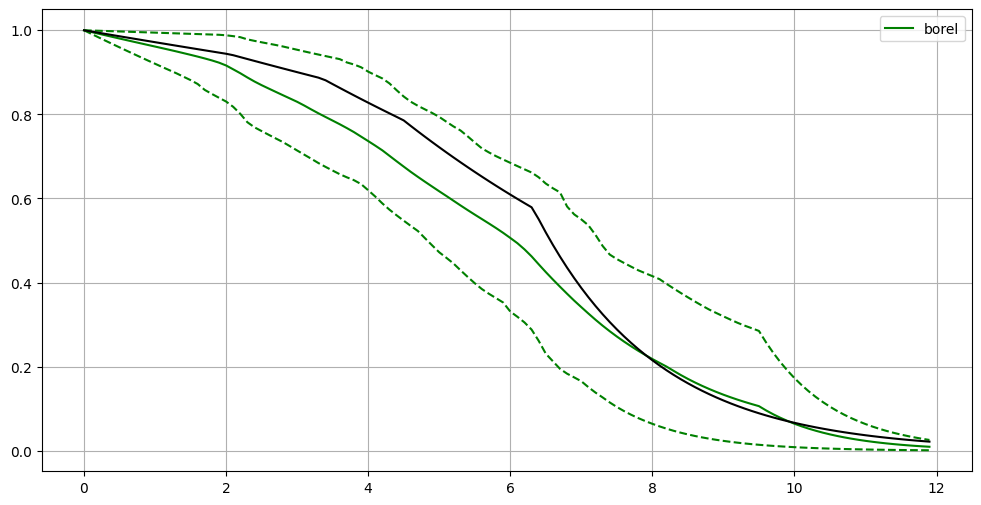

In [63]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

# plot_S1("poisson", None, 101, ci = True, show_sims = False, color = "red", ax = ax, outliers = 5)
# plot_S1("haight", None, 101, ci = True, show_sims = False, color = "blue", ax = ax, outliers = 5)
plot_S1("borel", None, 101, ci = True, show_sims = False, color = "green", ax = ax, outliers = 5)
# plot_S1("geometric", None, 64, ci = True, show_sims = False, color = "purple", ax = ax, outliers = 5)

plt.grid()
plt.legend()
plt.show()

In [13]:
def load_fitted_model(distribution, q, images, file_index):
    # Select the functions associated to the chosen distribution model
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution, q)
    log_a_tf = eval(log_a_str)
    log_phi_tf = eval(log_phi_str)
    C_tf = eval(C_str)
    C_inv_tf = eval(C_inv_str)
    sup_tf = eval(sup_str)

    simulation_path = "OASIS - Results/{}/{}".format(distribution, file_index)

    # ----------------------- Load data -----------------------
    # Indices for the images associated to this specific sample
    df_sample = pd.read_csv("OASIS - Small Dataset/bootstrap_sample/sample_{}.csv".format(file_index))

    imgs = images[ df_sample["image_index"] ]
    
    # ----------------------- Load results related to the fitted simulation ----------------------- 
    fitted_model = MPScrModel(log_a_tf, log_phi_tf, C_tf, C_inv_tf, sup_tf)
    fitted_model.define_structure(shape_input = images[0].shape)
    fitted_model.load_model("OASIS - Results/{}/{}/model.weights.h5".format(distribution, file_index))
    alpha_s_df = pd.read_csv("OASIS - Results/{}/{}/alpha_s.csv".format(distribution, file_index))
    pred_alpha = alpha_s_df["alpha"].to_numpy()
    s_t = alpha_s_df["s"].to_numpy()

    # ----------------------- Join everything in a single table -----------------------
    log_a_0 = log_a_tf(tf.constant(0.0, dtype = tf.float64))

    t = df_sample["time"].to_numpy()
    delta = df_sample["delta"].to_numpy()
    
    # Obtain all the predictions made using the trained model
    pred_eta = fitted_model.predict(imgs, verbose = 0)
    pred_p = fitted_model.link_func( pred_eta ).numpy().flatten()
    pred_log_p = np.log(pred_p)
    pred_theta = C_inv_tf( np.exp( log_a_0 - pred_log_p ) ).numpy().flatten()
    pred_m = update_m_mps(fitted_model, pred_alpha, s_t, imgs, t, delta)

    pred_S1 = S1(t, pred_alpha, s_t)    
    pred_Spop = Spop_known_S1(pred_S1, log_a_tf, log_phi_tf, pred_theta, sup_tf)
    
    df_summary = pd.DataFrame({"pred_theta": pred_theta, "pred_p": pred_p, "pred_m": pred_m,
                               "t": t, "delta": delta,
                               "pred_S1": pred_S1, "pred_Spop": pred_Spop,
                               "set": df_sample["set"].to_numpy()})

    # AUC_train = AUC_estimated( pred_p[df_sample["set"] == "train"] )
    # AUC_val = AUC_estimated( pred_p[df_sample["set"] == "val"] )
    # AUC_test = AUC_estimated( pred_p[df_sample["set"] == "test"] )
    
    return {
        "fit_model": fitted_model,
        "pred_alpha": pred_alpha,
        "pred_s_t": s_t,
        "imgs": imgs,
        "sets": df_sample["set"].to_numpy(),
        "log_a": log_a_tf,
        "log_phi": log_phi_tf,
        "C": C_tf,
        "C_inv": C_inv_tf,
        "sup": sup_tf,
        "summary": df_summary
        # "AUC_train": AUC_train,
        # "AUC_val": AUC_val,
        # "AUC_test": AUC_test
    }

In [59]:
result = load_fitted_model("geometric", None, img_oasis, 3)
result["fit_model"].predict(img_oasis, verbose = 0).flatten()[:20]

array([0.95237529, 0.95237529, 0.95237529, 0.95237541, 0.95237529,
       0.95237529, 0.95237529, 0.95237529, 0.95237529, 0.95237529,
       0.95237529, 0.95237529, 0.95237529, 0.95237529, 0.95238531,
       0.95237529, 0.95237529, 0.95237529, 0.95237529, 0.95237529])

In [62]:
result = load_fitted_model("borel", None, img_oasis, 1)
result["fit_model"].predict(img_oasis, verbose = 0).flatten()[:20]

array([1.22184408, 1.22184408, 1.22184408, 1.22184408, 1.22184408,
       1.22184408, 1.22184408, 1.22184408, 1.22184408, 1.22184408,
       1.22184408, 1.22184408, 1.22184408, 1.22184408, 1.22184408,
       1.22184408, 1.22184408, 1.22184408, 1.22184408, 1.22184408])

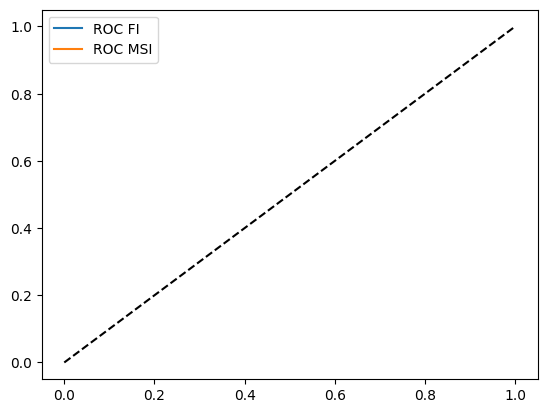

In [61]:
result = load_fitted_model("borel", None, img_oasis, 1)
fpr_FI, tpr_FI, thresholds_FI = ROC_estimate_FI(result["summary"]["pred_p"])
fpr_MSI, tpr_MSI, thresholds_MSI = ROC_estimate_MSI(result["summary"]["pred_p"], result["summary"]["delta"])

plt.step(fpr_FI, tpr_FI, label = "ROC FI")
plt.step(fpr_MSI, tpr_MSI, label = "ROC MSI")
plt.plot([0,1], [0,1], linestyle = "dashed", color = "black")
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc

def ROC_estimate_FI(pred_p):
    thresholds = np.unique(pred_p)
    # Reshape the cure_probs array for broadcasting
    pred_p = np.reshape(pred_p, (len(pred_p), 1))
    tpr = np.sum( (pred_p <= thresholds) * (1-pred_p), axis = 0 ) / np.sum( 1-pred_p )
    fpr = np.sum( (pred_p <= thresholds) * pred_p, axis = 0 ) / np.sum( pred_p )
    return fpr, tpr, thresholds

def AUC_estimated_FI(pred_p):
    fpr, tpr, thresholds = ROC_estimate_FI(pred_p)
    return auc(fpr, tpr)

def ROC_estimate_MSI(pred_p, delta):
    thresholds = np.unique(pred_p)
    # Reshape the cure_probs array for broadcasting
    pred_p = np.reshape(pred_p, (len(pred_p), 1))
    
    pred_v = np.ones_like(pred_p)
    pred_y = np.ones_like(pred_p)
    pred_v[delta == 1] = 1
    pred_y[delta == 1] = 1
    pred_v[delta == 0] = 0
    pred_y[delta == 0] = -1 # If delta_i is zero, then v_i = 0 and therefore y_i is unknown
    
    tpr = np.sum( (pred_p <= thresholds) * (pred_v * pred_y + (1-pred_v)*(1-pred_p)), axis = 0 ) / np.sum( (pred_v * pred_y + (1-pred_v)*(1-pred_p)) )
    fpr = np.sum( (pred_p <= thresholds) * (pred_v * (1-pred_y) + (1-pred_v)*pred_p), axis = 0 ) / np.sum( pred_v * (1-pred_y) + (1-pred_v)*pred_p )
    return fpr, tpr, thresholds

def AUC_estimated_MSI(pred_p, delta):
    fpr, tpr, thresholds = ROC_estimate_MSI(pred_p, delta)
    return auc(fpr, tpr)

In [ ]:
def recover_AUCs(distribution, q, images, end_index = 101):
    train_AUCs = []
    val_AUCs = []
    test_AUCs = []
    for j in tqdm(range(1, end_index)):
        results = load_fitted_model(distribution, q, images, j)
        train_AUCs.append( results["AUC_train"] )
        val_AUCs.append( results["AUC_val"] )
        test_AUCs.append( results["AUC_test"] )
    train_AUCs = np.array(train_AUCs)
    val_AUCs = np.array(val_AUCs)
    test_AUCs = np.array(test_AUCs)

    return train_AUCs, val_AUCs, test_AUCs

In [11]:
# train_AUCs_poisson, val_AUCs_poisson, test_AUCs_poisson = recover_AUCs("poisson", None, img_oasis, end_index = 101)
# train_AUCs_bernoulli, val_AUCs_bernoulli, test_AUCs_bernoulli = recover_AUCs("bernoulli", None, img_oasis, end_index = 101)
# train_AUCs_logarithmic, val_AUCs_logarithmic, test_AUCs_logarithmic = recover_AUCs("logarithmic", None, img_oasis, end_index = 101)
# train_AUCs_geometric, val_AUCs_geometric, test_AUCs_geometric = recover_AUCs("geometric", None, img_oasis, end_index = 79)
# train_AUCs_borel, val_AUCs_borel, test_AUCs_borel = recover_AUCs("borel", None, img_oasis, end_index = 101)
# train_AUCs_haight, val_AUCs_haight, test_AUCs_haight = recover_AUCs("haight", None, img_oasis, end_index = 101)

In [22]:
result = load_fitted_model("geometric", None, img_oasis, 1)
result["summary"]

,pred_theta,pred_p,pred_m,t,delta,pred_S1,pred_Spop,set
0,0.015972,0.984279,0.000169,12.189041,0,0.010764,0.984445,train
1,0.057608,0.945529,0.004844,10.082192,0,0.088502,0.950110,train
2,1.080784,0.480588,1.179588,9.498630,1,0.158632,0.523742,train
3,73.396519,0.013441,102.204596,2.035616,1,0.993982,0.693612,train
4,0.021356,0.979091,0.019961,4.663014,0,0.935973,0.998635,train
...,...,...,...,...,...,...,...,...
347,0.294050,0.772768,1.511392,5.126027,1,0.896128,0.970362,test
348,56.497850,0.017392,12.361205,4.600000,0,0.941532,0.232377,test
349,1.497860,0.400343,0.014175,11.416438,0,0.023308,0.406017,test
350,0.029244,0.971586,0.028377,3.227397,0,0.971145,0.999157,test


In [14]:
train_AUCs_borel, val_AUCs_borel, test_AUCs_borel = recover_AUCs("borel", None, img_oasis, end_index = 101)
train_AUCs_haight, val_AUCs_haight, test_AUCs_haight = recover_AUCs("haight", None, img_oasis, end_index = 101)

  0%|                                                                                                                                                                               | 0/100 [00:01<?, ?it/s]


ValueError: At least 2 points are needed to compute area under curve, but x.shape = 1